# WHS CHD MICCAI19 Dataset

This dataset consists of 68 3D CT images covering all seven key segmentation classes of the whole heart, along with additional anatomical structures. All images are provided with corresponding segmentation annotations.
*Publication Date: 2023.*

Original Paper: https://doi.org/10.1007/978-3-030-32245-8_53

Download Link: https://www.kaggle.com/datasets/xiaoweixumedicalai/chd68-segmentation-dataset-miccai19

Details: https://github.com/XiaoweiXu/Whole-heart-and-great-vessel-segmentation-of-chd_segmentation

In [1]:
import os
import torch

import nibabel as nib

ROOT_DIR = "/home/cayetana/Storage/code/cayetana-best/heart-segmentation"
os.chdir(ROOT_DIR)

DATA_PATH = "./data/datasets/CHD68_segmentation_dataset_miccai19"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 01. Visualization

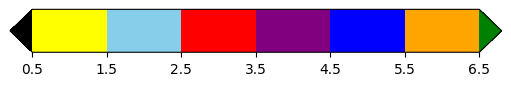

In [2]:
from heart_seg_app.utils.visualization import create_custom_cmap
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt

def create_custom_cmap(label_values : list, colors : list):
    under_color, over_color = colors[0], colors[-1]
    mid_bounds = [(label_values[i] + label_values[i+1]) / 2 for i in range(len(label_values)-1)]
    custom_cmap = matplotlib.colors.ListedColormap(list(colors)[1:], N=len(colors)).with_extremes(under=under_color, over=over_color)
    norm = matplotlib.colors.BoundaryNorm(mid_bounds, custom_cmap.N - 2)
    return custom_cmap, norm

def show_cmap(cmap, norm=None):
    fig, ax = plt.subplots(figsize=(5, 0.75), layout='constrained')
    fig.colorbar(
        matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=ax, orientation='horizontal',
        extend='both',
        spacing='proportional',
    )

mmwhs_label_map = {
    "background": {"color": "black", "value": 0.0},
    "left ventricle": {"color": "yellow", "value": 500.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 600.0, "description": "the right ventricle blood cavity"},
    "left atrium": {"color": "red", "value": 420.0, "description": "the left atrium blood cavity"},
    "right atrium": {"color": "purple", "value": 550.0, "description": "the right atrium blood cavity"},
    "myocardium": {"color": "blue", "value": 205.0, "description": "the myocardium of the left ventricle"},
    "ascending aorta": {"color": "orange", "value": 820.0, "description": "the ascending aorta"},
    "pulmonary artery": {"color": "green", "value": 850.0, "description": "the pulmonary artery"},
}

whs_chd_label_map = {
    "background": {"color": "black", "value": 0.0},
    "left ventricle": {"color": "yellow", "value": 1.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 2.0, "description": "the right ventricle blood cavity"},
    "left atrium": {"color": "red", "value": 3.0, "description": "the left atrium blood cavity"},
    "right atrium": {"color": "purple", "value": 4.0, "description": "the right atrium blood cavity"},
    "myocardium": {"color": "blue", "value": 5.0, "description": "the myocardium of the left ventricle"},
    "ascending aorta": {"color": "orange", "value": 6.0, "description": "the ascending aorta"},
    "pulmonary artery": {"color": "green", "value": 7.0, "description": "the pulmonary artery"},
}

order = [0, 3, 5, 2, 4, 1, 6, 7] # in accordance with MMWHS Dataset (Model output order)
label_values = [meta["value"] for meta in whs_chd_label_map.values()]
colors = [meta["color"] for meta in whs_chd_label_map.values()]

cmap, norm = create_custom_cmap(label_values, colors)
show_cmap(cmap, norm)

In [3]:
def collect_images_labels(image_dir, label_dir, postfix=".nii.gz"):
    images = []
    labels = []
    for path in sorted(os.listdir(image_dir)):
        if path.endswith(f"image{postfix}"):
            images.append(os.path.join(image_dir, path))

    for path in sorted(os.listdir(label_dir)):
        if path.endswith(f"label{postfix}"):
            labels.append(os.path.join(label_dir, path))

    dataset = []    
    for images, labels in zip(images, labels):
        dataset.append({"image": images, "label": labels})
    
    return dataset

dataset = collect_images_labels(image_dir=DATA_PATH, label_dir=DATA_PATH, postfix=".nii.gz")
dataset[0], len(dataset)

({'image': './data/datasets/CHD68_segmentation_dataset_miccai19/ct_1001_image.nii.gz',
  'label': './data/datasets/CHD68_segmentation_dataset_miccai19/ct_1001_label.nii.gz'},
 68)

In [4]:
class NIfTIDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image_path, label_path = self.dataset[idx]["image"], self.dataset[idx]["label"]

        image = nib.load(image_path)
        label = nib.load(label_path)

        return image, label

nifti_dataset = NIfTIDataset(dataset)

(512, 512, 221)


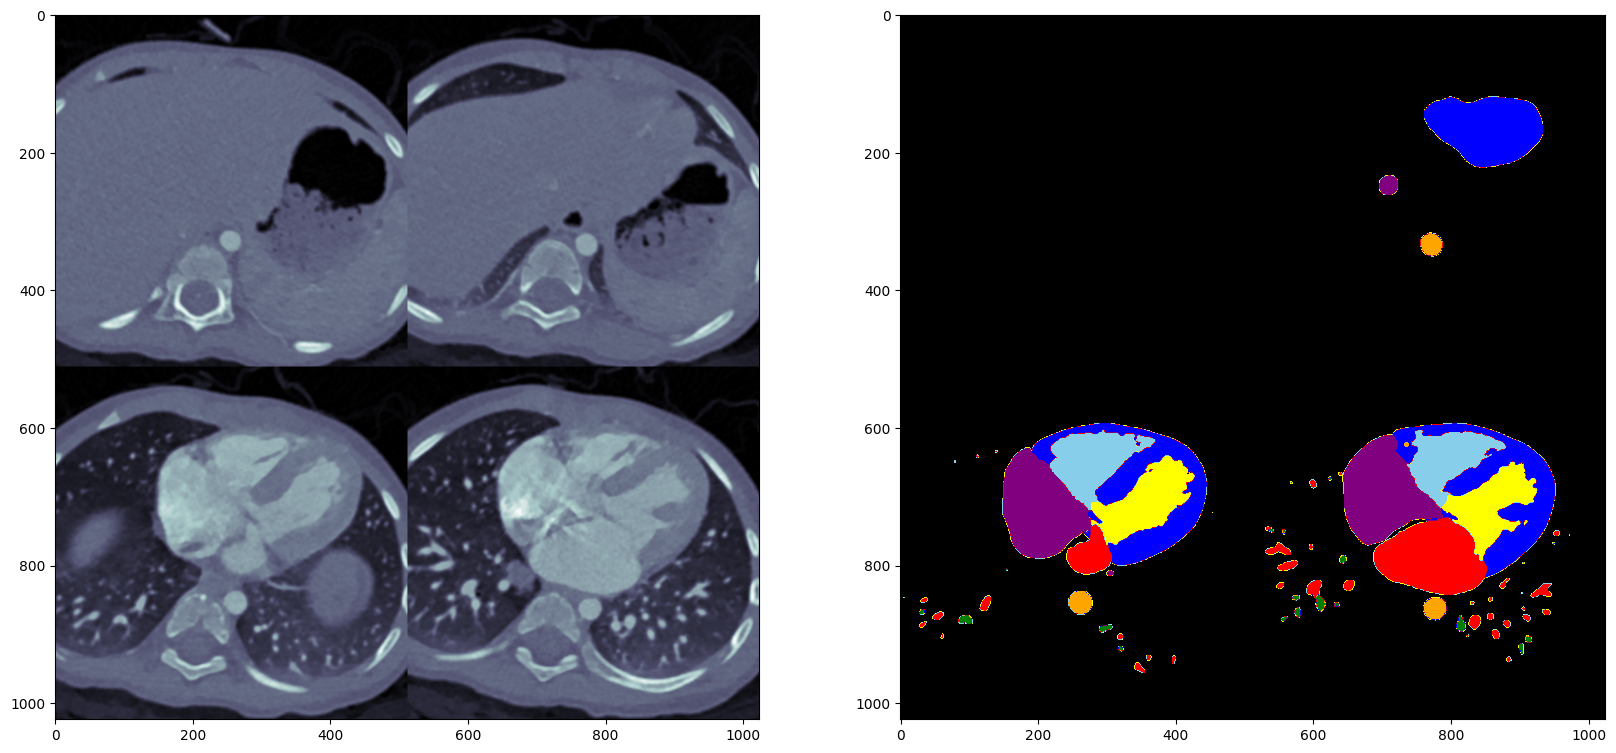

In [5]:
import skimage
import matplotlib.pyplot as plt

image, label = nifti_dataset[0]
print(image.shape)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(skimage.util.montage(image.get_fdata().T[:100:25]), cmap="bone")
ax[1].imshow(skimage.util.montage(label.get_fdata().T[:100:25]), cmap=cmap, norm=norm)

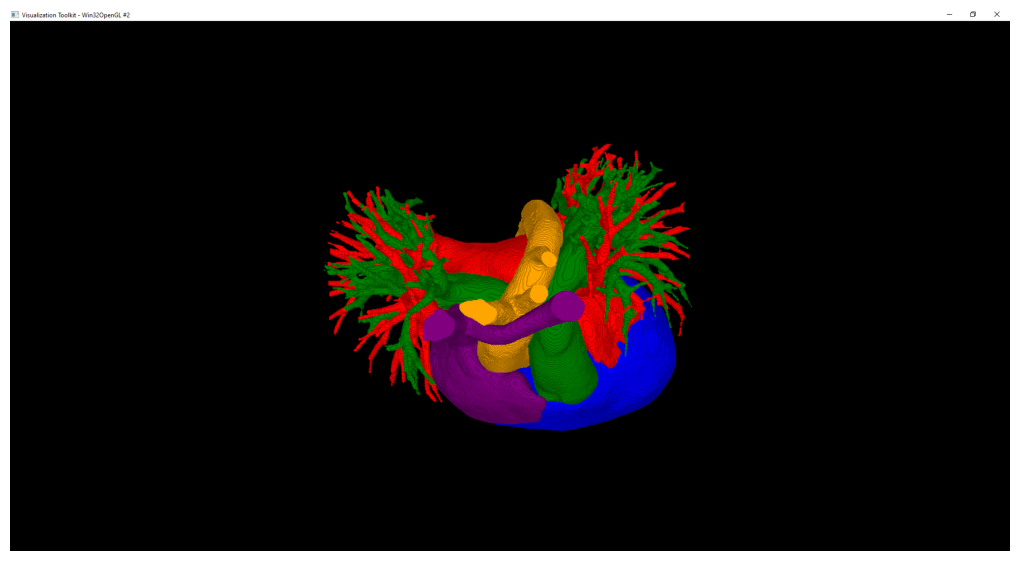

In [6]:
from heart_seg_app.utils.visualization import vtk_visualize_3d

vtk_visualize_3d(label.get_fdata(), label_values, colors)

image = plt.imread("./figures/vtk-miccai19.png")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax.imshow(image)

## 02. Data Preprocessing

In [ ]:
from tqdm import tqdm
import scipy.ndimage
import numpy as np

def nii_to_npy_preprocessing(image_dir, label_dir, prefix="", postfix=""):

    for path in tqdm(os.listdir(image_dir)):
        if path.startswith(prefix) and path.endswith(f"image.nii{postfix}"):
            image : nib.Nifti1Image = nib.load(os.path.join(image_dir, path))
            print(image.shape, end=" ")
            image = image.get_fdata()
            scales = [256.0/image.shape[0], 256.0/image.shape[1], 128.0/image.shape[2]]
            print(scales)
            scaled_image = scipy.ndimage.zoom(image, scales, mode="reflect")
            print(scaled_image.shape)
            np.save(os.path.join(image_dir, path + ".256256128.npy"), scaled_image)
        
    for path in tqdm(os.listdir(label_dir)):
        if path.startswith(prefix) and path.endswith(f"label.nii{postfix}"):
            label : nib.Nifti1Image = nib.load(os.path.join(label_dir, path))
            label = label.get_fdata()
            scales = [256.0/label.shape[0], 256.0/label.shape[1], 128.0/label.shape[2]]
            scaled_label = scipy.ndimage.zoom(label, scales, order=0, mode="reflect")
            np.save(os.path.join(label_dir, path + ".256256128.npy"), scaled_label)

# nii_to_npy_preprocessing(DATA_PATH, DATA_PATH, postfix=".gz")

100%|██████████| 204/204 [00:49<00:00,  4.11it/s]


In [17]:
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from heart_seg_app.utils.dataset import get_dataset_statistic

class WHSCHDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image_path, label_path = self.dataset[idx]["image"], self.dataset[idx]["label"]

        image = np.load(image_path)
        label = np.load(label_path)
        
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

dataset = collect_images_labels(DATA_PATH, DATA_PATH, postfix=".nii.gz.256256128.npy")
whschd_dataset = WHSCHDDataset(dataset)
test_dataloader = DataLoader(whschd_dataset)
mean, std = get_dataset_statistic(test_dataloader)
print(f"mean = {mean:.2f}, std = {std:.2f}")

mean = 632.35, std = 535.56


In [28]:
from torch.utils.data import DataLoader

class ImagePreprocessing(object):
    def __init__(self, train_mean, train_std, test_mean, test_std):
        self.train_mean = train_mean
        self.train_std = train_std
        self.test_mean = test_mean
        self.test_std = test_std
        
    def __call__(self, image : torch.Tensor):
        # image = (image - image.min()) / (image.max() - image.min())
        # train_mean, train_std = -798.5996078491211, 1057.2967376708984
        # test_mean, test_std = 632.3508484784295, 517.6749940759995
        image = (image - self.test_mean) / self.test_std * self.train_std + self.train_mean
        image = torch.unsqueeze(image, dim=0)
        return image

class LabelPreprocessing(object):
    def __init__(self, label_values):
        self.label_values = label_values

    def __call__(self, label : torch.Tensor):
        processed_label = torch.zeros(size=(len(self.label_values), *label.shape), dtype=torch.int32)
        for i, value in enumerate(self.label_values):
            processed_label[i] = torch.where(label == value, 1.0, 0.0)
        return processed_label

class SortLabels(object):
    def __init__(self, sorted_labels : list):
        self.sorted_labels = sorted_labels

    def __call__(self, label : np.ndarray):
        label = label[self.sorted_labels, :, :, :]
        return label

test_dataset = WHSCHDDataset(
    dataset,
    transform=transforms.Compose([
        ImagePreprocessing(train_mean=-798.60, train_std=1132.57, test_mean=632.35, test_std=535.56),
    ]),
    target_transform=transforms.Compose([
        LabelPreprocessing(label_values),
        # SortLabels(sorted_labels=[0, 3, 5, 2, 4, 1, 6, 7])
    ]),
)

test_dataloader = DataLoader(test_dataset, batch_size=1)
mean, std = get_dataset_statistic(test_dataloader)
print(f"mean = {mean:.2f}, std = {std:.2f}")

mean = -798.60, std = 1132.57


## 03. Download model & evaluate

In [ ]:
import heart_seg_app.models.unet3d as unet3d

hparams = {
        'n_channels':1,
        'n_classes':8,
    }
model = unet3d.Unet3D(None, test_dataloader, hparams)
CHECKPOINT_PATH = 'checkpoints/mmwhs_v1.ckpt'
checkpoint_file = torch.load(CHECKPOINT_PATH, weights_only=False)
model.load_state_dict(checkpoint_file['state_dict'])
model = model.to(device)

{'n_channels': 1, 'n_classes': 8}


In [23]:
from tabulate import tabulate
import pandas as pd
from tqdm import tqdm
from heart_seg_app.utils.metrics import Dice

dice = Dice()
label_names = whs_chd_label_map.keys()
table = pd.DataFrame({"idx": [], **{label_name: float for label_name in label_names}, "mean": []})

def mmwhs_label_postprocessing(label: torch.Tensor, label_values, order, device):
    label = label[:, order, ...]
    label = torch.softmax(label, dim=1).argmax(dim=1)
    batch_size, *spatial_size = label.size()
    processed_label = torch.zeros(size=(batch_size, len(label_values), *spatial_size), dtype=torch.int32, device=device)
    for i, value in enumerate(label_values):
        processed_label[:, i] = torch.where(label == value, 1, 0)

    return processed_label

with torch.no_grad():
    model.eval()
    for (inputs, targets) in tqdm(test_dataloader):
        inputs : torch.Tensor; targets : torch.Tensor
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        order = [0, 3, 5, 2, 4, 1, 6, 7]
        processed_outputs = mmwhs_label_postprocessing(outputs, label_values=list(range(8)), order=order, device=device)
        dice_by_classes = dice(processed_outputs, targets)
        mean_dice = dice.mean()
        new_row = pd.DataFrame([["image_idx", *dice_by_classes, mean_dice]], columns=table.columns)
        table = pd.concat([table, new_row], ignore_index=True)
        
        
print(tabulate(table, headers=list(table.columns), tablefmt="fancy_grid", numalign="center"))

100%|██████████| 68/68 [00:42<00:00,  1.61it/s]


╒════╤═══════════╤══════════════╤══════════════════╤═══════════════════╤═══════════════╤════════════════╤══════════════╤═══════════════════╤════════════════════╤══════════╕
│    │ idx       │  background  │  left ventricle  │  right ventricle  │  left atrium  │  right atrium  │  myocardium  │  ascending aorta  │  pulmonary artery  │   mean   │
╞════╪═══════════╪══════════════╪══════════════════╪═══════════════════╪═══════════════╪════════════════╪══════════════╪═══════════════════╪════════════════════╪══════════╡
│ 0  │ image_idx │   0.963259   │     0.279551     │         0         │   0.278898    │   0.0131267    │   0.139689   │     0.122996      │    2.89515e-05     │ 0.224694 │
├────┼───────────┼──────────────┼──────────────────┼───────────────────┼───────────────┼────────────────┼──────────────┼───────────────────┼────────────────────┼──────────┤
│ 1  │ image_idx │   0.975775   │    0.00627455    │         0         │   0.0814633   │   0.0179299    │   0.136758   │     0.0397781 

## 04. Result Visualization

In [24]:
with torch.no_grad():
    model.eval()
    it = iter(test_dataloader)
    batch = next(it)
    image, label = batch[0].to(device), batch[1].to(device)
    output = model(image)
    order = [0, 3, 5, 2, 4, 1, 6, 7]
    processed_outputs = mmwhs_label_postprocessing(outputs, label_values=list(range(8)), order=order, device=device)
    
    image = image[0].squeeze().cpu()
    label = label.argmax(dim=1)[0].cpu()
    preds = processed_outputs.argmax(dim=1)[0].cpu()
    print(image.shape, label.shape, preds.shape)

torch.Size([256, 256, 128]) torch.Size([256, 256, 128]) torch.Size([256, 256, 128])


torch.Size([256, 256, 128]) torch.Size([256, 256, 128])


Text(0.5, 1.0, 'Prediction')

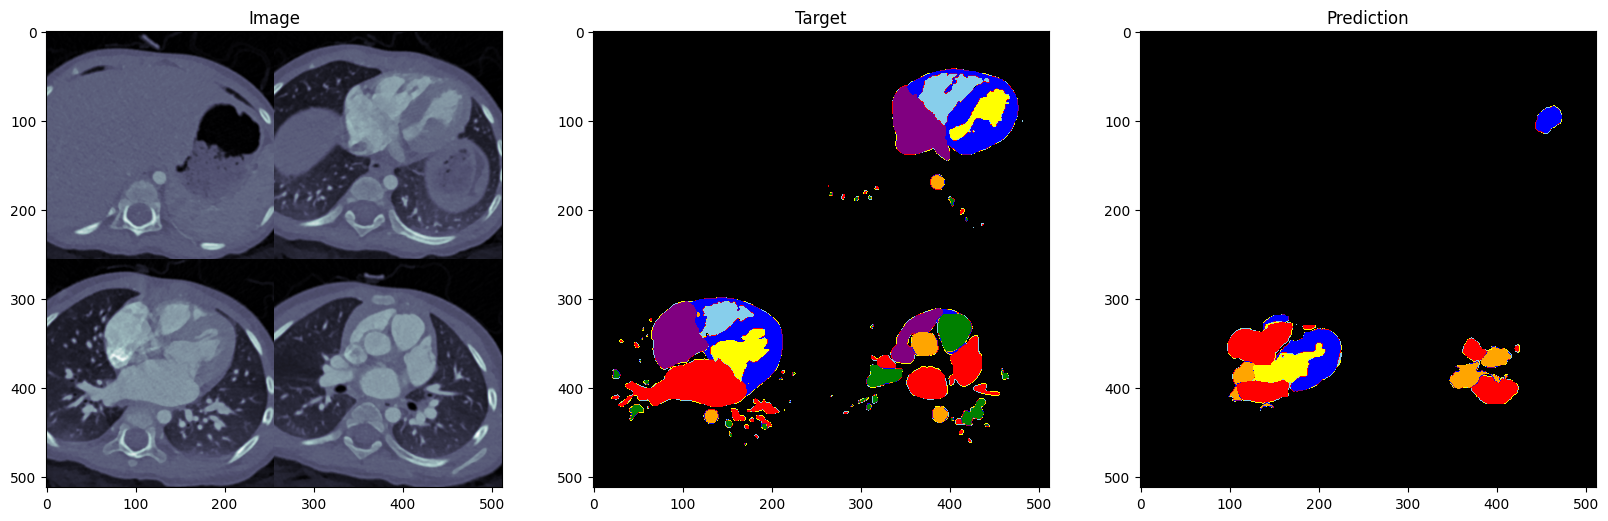

In [26]:
import skimage
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 20))

print(image.shape, label.shape)

ax[0].imshow(skimage.util.montage(image.T[0:100:25]), cmap="bone")
ax[1].imshow(skimage.util.montage(label.T[0:100:25]), cmap=cmap, norm=norm)
ax[2].imshow(skimage.util.montage(preds.T[0:100:25]), cmap=cmap, norm=norm)
ax[0].set_title("Image")
ax[1].set_title("Target")
ax[2].set_title("Prediction")

In [27]:
from heart_seg_app.utils.visualization import vtk_visualize_3d

vtk_visualize_3d(preds, label_values, colors)